In [420]:
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

if ".." not in sys.path:
    sys.path.append("..")

os.makedirs("figs/fig1", exist_ok=True)

import numpy as np

from experiments.data.shapes import generate_heart, generate_star
from experiments.data.shapes import HeartDataProvider,StarDataProvider

from experiments import EXPERIMENTS_DATA_DIR
HEART_IMG = EXPERIMENTS_DATA_DIR / "heart.png"

mpl.rcParams['font.size'] = 14


# Figure 1

## Shape datasets

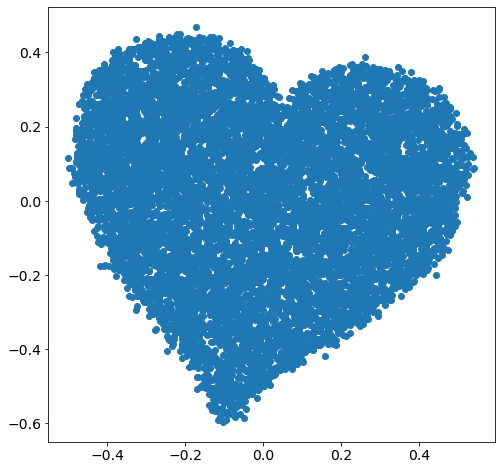

In [421]:
heart_dp = HeartDataProvider(initial_rotation_deg=90, noise_std=0.01, x_max_deg=10,
                             x_discrete=True)

X, Y = heart_dp.sample(n=10000, x=10)

fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])

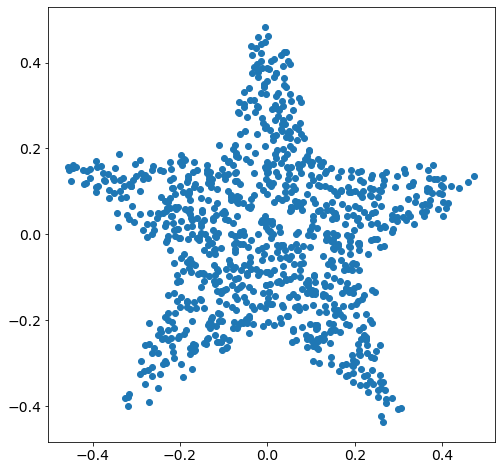

In [422]:
star_dp = StarDataProvider(initial_rotation_deg=0, noise_std=0.01, x_discrete=True,)

X, Y = star_dp.sample(n=1000, x=20)

fig = plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1])

## Fitting VQE

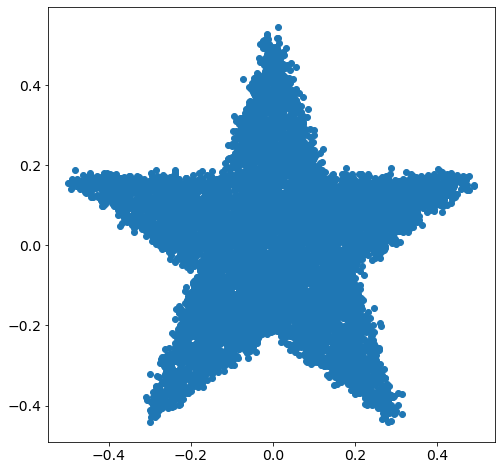

In [423]:
from vqr import VectorQuantileEstimator
from vqr.plot import plot_quantiles,plot_quantiles_3d
from vqr.vqr import check_comonotonicity

star_dp = StarDataProvider(initial_rotation_deg=90, noise_std=0.01, x_max_deg=20, x_discrete=True)

_, Y_star = star_dp.sample(n=10000, x=0)

fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.scatter(Y_star[:, 0], Y_star[:, 1])

In [424]:

solver = "vqe_pot"
solver_opts = {'numItermax': int(2e6)}

# solver = "regularized_dual"
# solver_opts = {'epsilon': 1e-5, "verbose": True}

T = 50
vq2 = VectorQuantileEstimator(
    n_levels=T,
    solver=solver,
    solver_opts=solver_opts,
)
vq2.fit(Y_star)


VectorQuantileEstimator(solver=<vqr.solvers.primal.pot.POTVQESolver object at 0x3e0c2f3d0>,
                        solver_opts={'numItermax': 2000000})

## Figure 1A: Vector Quantiles


An $\alpha$-contour contains $100\cdot(1-2\alpha)^d$ percent of the data and can be
seen as the vector quantile equivalent of a confidence interval.

Each point on these contours is the value of a vector quantile, i.e. $Q_{Y}(\mathbf{u})
$ for some $\mathbf{u}$.

violations (refine=True): 0.0


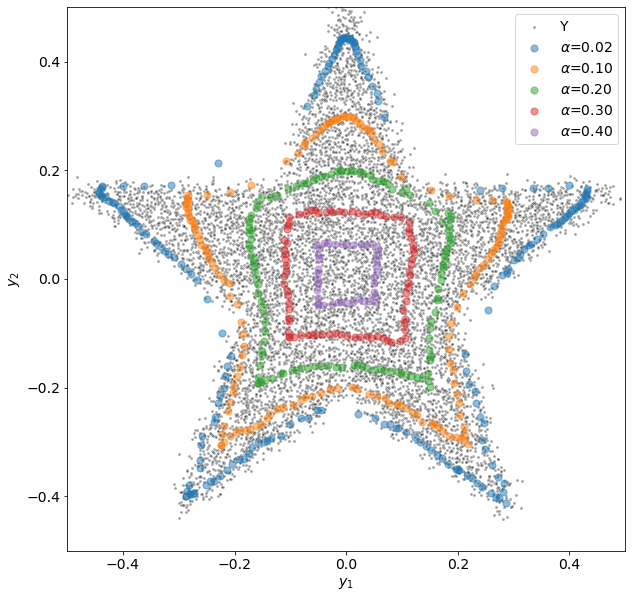

In [425]:
from vqr.plot import plot_contour_2d
from vqr.vqr import check_comonotonicity

alphas = [0.02, 0.1, 0.2, 0.3, 0.4]
refines = [True]
xylim = [-.5,.5]

fig, axes = plt.subplots(1, len(refines), figsize=(10*len(refines), 10), squeeze=False)

for i, (ax, refine) in enumerate(zip(axes.reshape(-1), refines)):
    Qs = list(vq2.vector_quantiles(refine=refine))
    Us = vq2.quantile_grid

    plot_contour_2d(
        Qs=Qs, alphas=alphas, ax=ax, Y=Y_star,
    )
    # ax.set_title(f"{refine=}")
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.set_xlabel("$y_1$"); ax.set_ylabel("$y_2$");

    violations = check_comonotonicity(T, d=2, Qs=Qs, Us=Us) < 0
    print(f"violations ({refine=}): {np.sum(violations) / np.prod(violations.shape)}")

fig.savefig("figs/fig1/fig1a.png", dpi=150, bbox_inches="tight")


## Figure 1B: Vector quantile component surfaces

Each surface represents a component of the vector quantile function.
On Q1, walking along u1 with a fixed u2 yields a monotonically increasing quantile
curve, and vice versa for Q2.

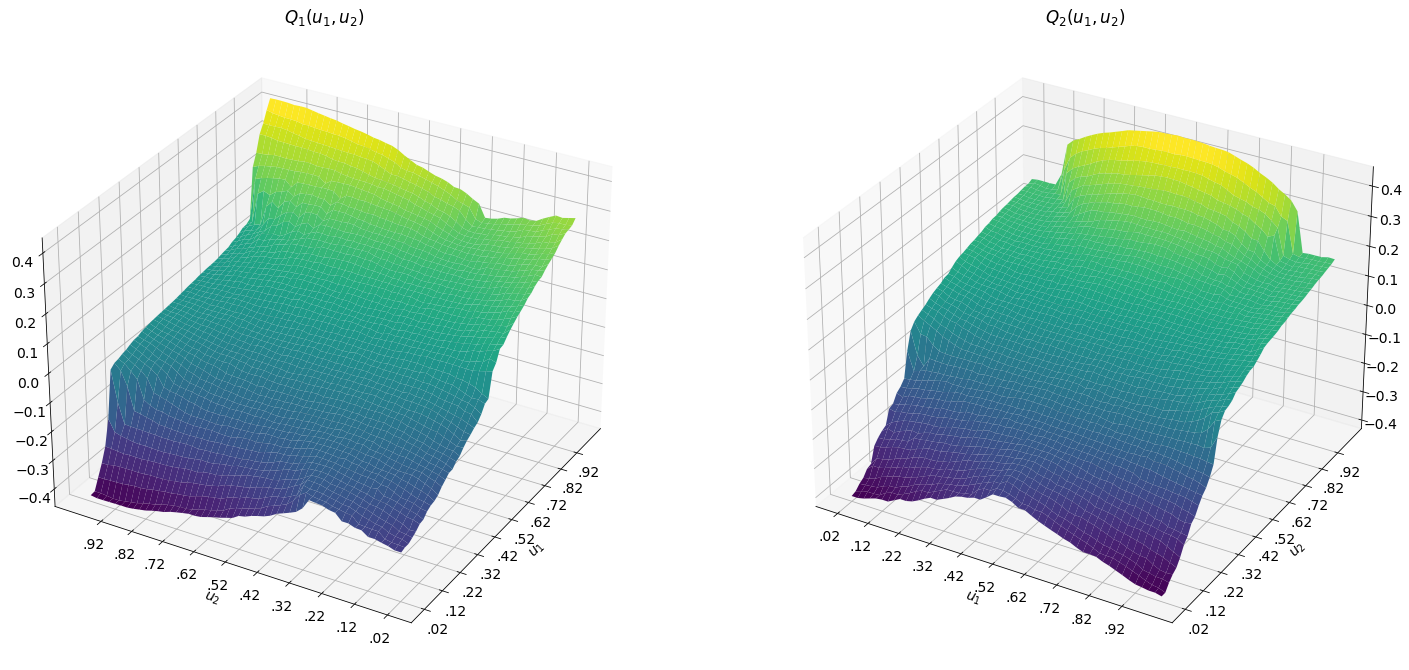

In [426]:
from vqr.plot import plot_quantiles_3d

fig, axes = plot_quantiles_3d(
    T, d=2,
    Qs=vq2.vector_quantiles(refine=True),
    Us=vq2.quantile_grid, figsize=(25, 20),
    colorbar=False,
)
axes[0].view_init(axes[0].elev, -150)

fig.savefig("figs/fig1/fig1b.png", dpi=150, bbox_inches="tight")


## Figure 1C: Conditional quantiles

Here quantiles function of the data depend nonlinearly on $x$: the distribution of
$Y|X=x$ is the distribution of $Y$ rotated by $x$ degrees.
We show contours of different CVQFs, i.e. given different values of $x$.

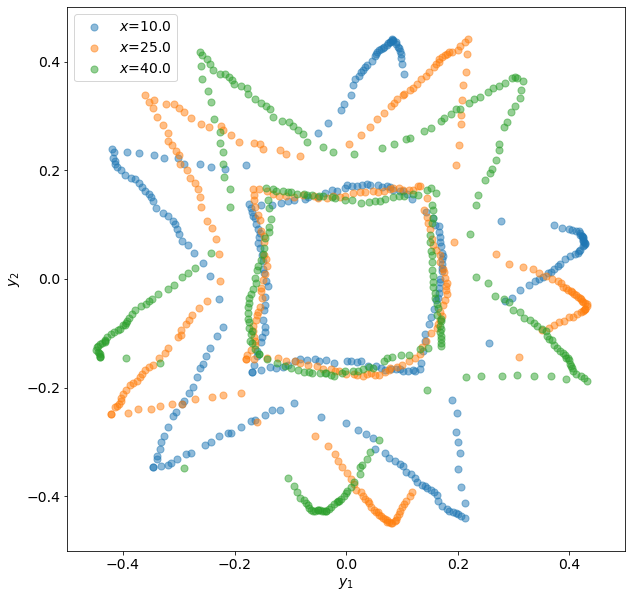

In [427]:

X = np.array([[10], [25], [40]])

fig, ax = plt.subplots(1, 1, figsize=(10, 10), squeeze=True)
xylim = [-.5,.5]

for i, x in enumerate(X):
    _, Y_star = star_dp.sample(n=10000, x=x)

    # Using VQE per x instead of VQR on all the data since it's faster and it's just
    # used for the plot.
    vq2 = VectorQuantileEstimator(
        n_levels=T,
        solver=solver,
        solver_opts=solver_opts,
    )
    vq2.fit(Y_star)

    plot_contour_2d(
        Qs=vq2.vector_quantiles(), alphas=(0.02, 0.22), ax=ax,
        alpha_labels=(f'$x$={x.item():.1f}',''),
        alpha_colors=(f'C{i}',f"C{i}")
    )
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.set_xlabel("$y_1$"); ax.set_ylabel("$y_2$");

fig.savefig("figs/fig1/fig1c.png", dpi=150, bbox_inches="tight")
